# X-Ray Image Pneaumonia Detection

## Objective

To build a convolutional neural network to detect pneumonia from chest X-ray images. 

## Dataset

Taken from [kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). It contains 5863 images with 2 categories organise into train, test and validation sets.

## Libraries

In [3]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import seaborn as sns; sns.set_style("darkgrid")
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import *

## EDA

In [5]:
base_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_path = base_path + "/train"
val_path = base_path + "/val"
test_path = base_path + "/test"

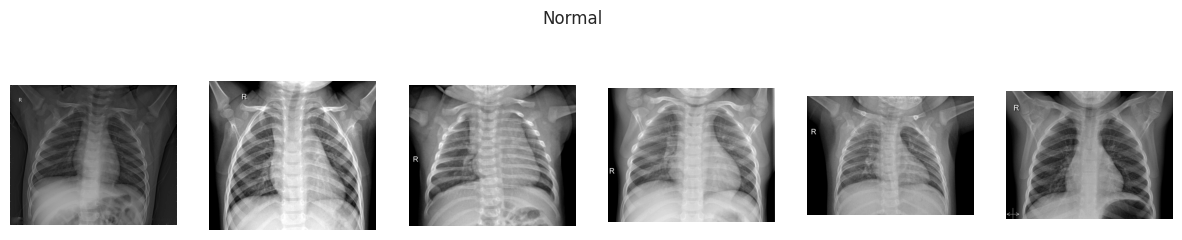

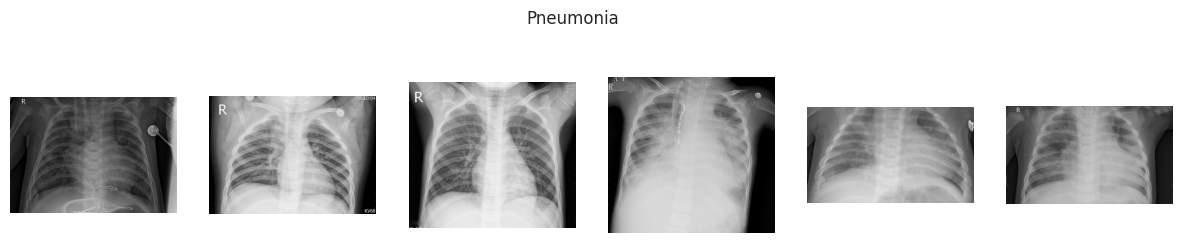

In [6]:
norm_imgs = [train_path+"/NORMAL/" + i for i in os.listdir(train_path+"/NORMAL")[:6]]
pne_imgs = [train_path+"/PNEUMONIA/" + i for i in os.listdir(train_path+"/PNEUMONIA")[:6]]


fig,ax=plt.subplots(1,len(norm_imgs),figsize=(15,3))
for i in range(len(norm_imgs)):
    img = cv2.imread(norm_imgs[i],cv2.IMREAD_GRAYSCALE)
    ax[i].imshow(img,cmap="gray")
    ax[i].axis("off")
fig.suptitle("Normal")

fig2,ax2=plt.subplots(1,len(norm_imgs),figsize=(15,3))
fig2.suptitle("Pneumonia")
for i in range(len(pne_imgs)):
    img = cv2.imread(pne_imgs[i],cv2.IMREAD_GRAYSCALE)
    ax2[i].imshow(img,cmap="gray")
    ax2[i].axis("off")

I can't really tell the difference, maybe because I'm not a doctor. But I hope AI can!

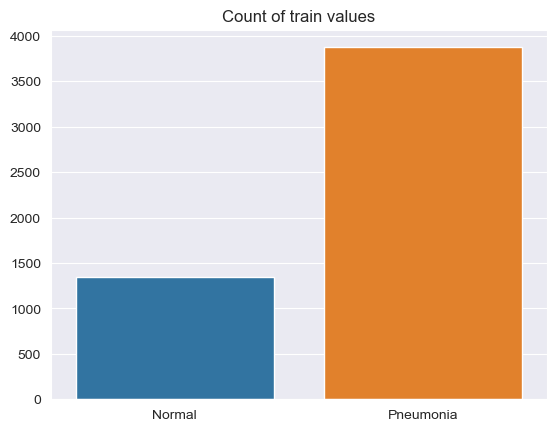

In [83]:
classes = ["Normal","Pneumonia"]
class_value_counts = [len(os.listdir(train_path+"/NORMAL")),len(os.listdir(train_path+"/PNEUMONIA"))]
sns.barplot(y=class_value_counts,x=classes)
plt.title("Count of train values")
plt.show()

Here we have the problem of imbalanced classes. 
There are a few ways to solve this:
- Oversample minority class by augmenting images
- Adjust class weight to incentivise model to predict minority class better
- Use a different loss function that is designed for imbalance

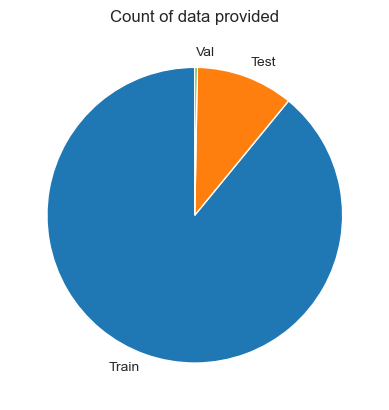

In [84]:
files = ["Train","Test","Val"]
value_counts = [len(os.listdir(train_path+"/NORMAL"))+len(os.listdir(train_path+"/PNEUMONIA")),
                len(os.listdir(test_path+"/NORMAL"))+len(os.listdir(test_path+"/PNEUMONIA")),
                len(os.listdir(val_path+"/NORMAL"))+len(os.listdir(val_path+"/PNEUMONIA"))]
plt.pie(x=value_counts,labels=files,startangle=90)
plt.title("Count of data provided")
plt.show()

As you can see there is too little validation data. Thus maybe we shoud get a portion of the train set to act as validation set.

## Preprocessing
We will get the data loaded and then split some validation data. We will be using Keras inbuiild ImageDataGenerator. We will also rescale scaled to 0-1 to make it easy for deep learning algorithm to process

In [124]:
IMG_SIZE = 300
BATCH_SIZE = 16

datagen1 = ImageDataGenerator(rescale = 1./255,validation_split=0.1)
datagen2 = ImageDataGenerator(rescale = 1./255)

train_batch = datagen2.flow_from_directory(directory=train_path,target_size=(IMG_SIZE,IMG_SIZE),classes=["NORMAL","PNEUMONIA"],
                                            shuffle=True,class_mode = 'binary',batch_size=BATCH_SIZE)

val_batch = datagen2.flow_from_directory(directory=val_path,target_size=(IMG_SIZE,IMG_SIZE),classes=["NORMAL","PNEUMONIA"],
                                    shuffle=True,class_mode = 'binary',batch_size=1)

test_batch = datagen2.flow_from_directory(directory=test_path,target_size=(IMG_SIZE,IMG_SIZE),classes=["NORMAL","PNEUMONIA"],
                                        shuffle=True,class_mode = 'binary',batch_size=624)

Found 5216 images belonging to 2 classes.

Found 16 images belonging to 2 classes.

Found 624 images belonging to 2 classes.


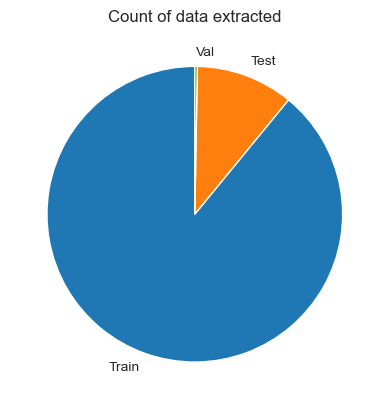

In [86]:
value_counts = [train_batch.samples, test_batch.samples, val_batch.samples]
plt.pie(x=value_counts,labels=files,startangle=90)
plt.title("Count of data extracted")
plt.show()

Looks much better.

## CNN
Adding dense layers increases model complexity exponentially so we will stick to a light weight model and make best use of it. Since the images are fairly similiar, Convolution in multiple layers should be sufficient. 

In [112]:
EPOCHS = 10
tf.keras.backend.clear_session()
cnn = Sequential()
focalLoss = tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True,gamma=4)
cnn.add(Conv2D(16, (2, 2), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (2, 2), activation="relu"))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (2, 2), activation="relu"))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'sigmoid', units = 1))

cnn.compile(optimizer = 'adam', 
            loss = focalLoss, metrics = ['accuracy'])

es = EarlyStopping(monitor="loss",patience=2)


In [113]:
history2 = cnn.fit(train_batch, epochs=EPOCHS, validation_data=val_batch,callbacks=[es])

Epoch 1/10

326/326 [==============================] - 67s 203ms/step - loss: 0.0100 - accuracy: 0.8884 - val_loss: 0.0065 - val_accuracy: 0.9375

Epoch 2/10

326/326 [==============================] - 66s 203ms/step - loss: 0.0027 - accuracy: 0.9628 - val_loss: 0.0039 - val_accuracy: 0.9375

Epoch 3/10

326/326 [==============================] - 64s 196ms/step - loss: 0.0021 - accuracy: 0.9718 - val_loss: 0.0169 - val_accuracy: 0.9375

Epoch 4/10

326/326 [==============================] - 66s 202ms/step - loss: 0.0016 - accuracy: 0.9795 - val_loss: 0.0039 - val_accuracy: 0.9375

Epoch 5/10

326/326 [==============================] - 66s 203ms/step - loss: 0.0014 - accuracy: 0.9803 - val_loss: 0.0313 - val_accuracy: 0.8750

Epoch 6/10

326/326 [==============================] - 66s 202ms/step - loss: 0.0013 - accuracy: 0.9820 - val_loss: 0.0019 - val_accuracy: 1.0000

Epoch 7/10

326/326 [==============================] - 67s 205ms/step - loss: 7.6116e-04 - accuracy: 0.9881 - val_loss

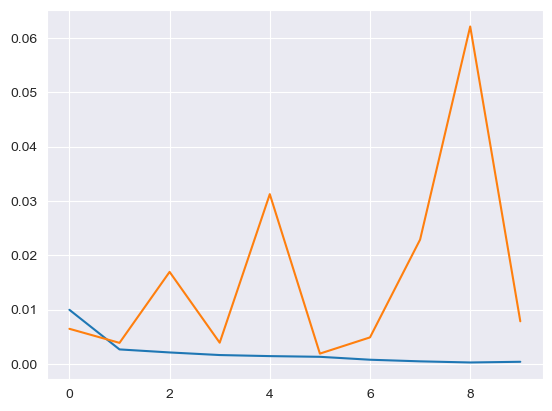

In [114]:
sns.lineplot(x=range(0,EPOCHS),y=history2.history["loss"]) 
sns.lineplot(x=range(0,EPOCHS),y=history2.history["val_loss"]) 
plt.title('Training vs Validation Loss')
plt.show()

Validation loss seems abit rough but maybe its due to small validation set

In [115]:
test_loss, test_score = cnn.evaluate(test_batch)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 6s 10ms/step - loss: 0.2410 - accuracy: 0.7901

Loss on test set:  0.24095027148723602

Accuracy on test set:  0.7900640964508057


In [153]:
test_arr = []
test_label = []
for i in range( test_batch.__len__() ):
    test_arr.extend(
        test_batch.__getitem__( i )[0] 
        )
    test_label.extend(test_batch.__getitem__( i )[1] )
test_arr = np.array(test_arr)
test_label = np.array(test_label)

20/20 [==============================] - 1s 44ms/step


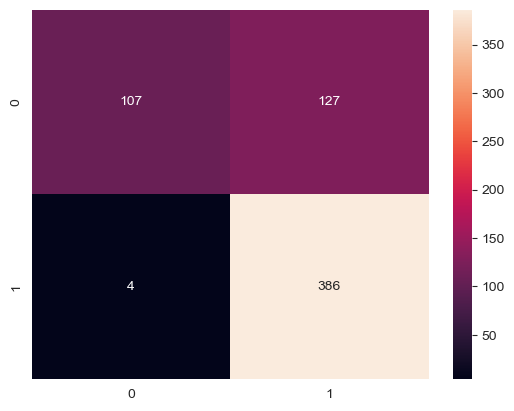

In [161]:
cm = confusion_matrix(test_label,np.squeeze((cnn.predict(test_arr)>=0.5).astype(int)))
sns.heatmap(cm,annot=True,fmt='g')
plt.show()

For this usecase, seems reasonable good as it predicts the Pneumonia cases correctly while it struggles to classify normal cases. Probably due to data imbalance